# Machine Learing Nano Degree
## Gender Recognition by Voice
## Model Training

In this project, I will try several **suprivised** machine learning algorithm on 3168 samples to predict gender accurately.

First, I will try several models. Then, the best model will be optimized to achieve best performance.

My goal is to construct a model to predict gender accurately.

Dataset comes from [kaggle](https://www.kaggle.com/primaryobjects/voicegender). Features have been extracted by R packages, seewave and tuneR.

---
## Preparation
Load the necessary Python libraries and load preprocessed sets.

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
%matplotlib inline

In [243]:
with open('train_set.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)

In [244]:
with open('val_set.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

In [245]:
with open('test_set.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [246]:
with open('all_feature_min_max.pkl', 'rb') as f:
    features_min, features_max = pickle.load(f)

---
## Evaluation of Performance

### Evaluation Standards
This project is aimed to distinguish voice of male and female. The importance equals. So precision and recall rate means nothing. Thus, **accuracy** is evaluation standards.

### Naive Model
If we simply predict every voice is female, we can achieve an accuracy of 50%.

## Surprivised Machine Learning Models
### Candidate Models
- LogisticRegression
- DecisionTree
- RandomForest
- SVM

### Advantages and Disadvantages
Reference:

- http://blog.sciencenet.cn/blog-520608-745856.html
- https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms
- http://idatamining.net/blog/?p=1179

#### Model 1
- Name: LogisticRegression
- Advantages:
    - Fast
    - Simple
    - Giving correlation of features
- Disadvantages:
    - Cannot work well directly at dataset of unlinear correlation
    - Needing conversion for more complex correlation
    - Easily under-fitted
    - Poor at large feature space

#### Model 2
- Name: DecisionTree
- Advantages:
    - Able to describe nonlinear correlation
    - Fast
    - Explanatory
    - Compatible with missing features
- Disadvantage:
    - Easily over-fitted

#### Model 3
- Name: RandomForest
- Advantages:
    - Able to process large feature space
    - Compatible with missing features
    - Explanatory
- Disadvantages:
    - Over-fit at dataset with much noise

#### Model 4
- Name: SVM
- Advantages:
    - Generalization
    - Able to process nolinear correlation
- Disadvantages:
    - Sensible to kernel function
    - Slow
    - Little explanatory

### Create Predicting and Evaluating Pipeline

In [247]:
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    Automatically train, predict model and record consuming time.
    : learner: the model to be trained and predicted
    : sample_size: the size of samples to train
    : X_train: features of training set
    : y_train: label of training set
    : X_val: features of validation set
    : y_val: label of validation set
    : return: a dict containing "train_time", "pred_time", "acc_train", "acc_val".
    '''
    
    results = {}
    
    # train and record time
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # get time for training
    results['train_time'] = end - start
    
    # predict validation and train set, and record time
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()
    #predictions_train = [round(value) for value in predictions_train]
    #predictions_val = [round(value) for value in predictions_val]
    
    # get predict time
    results['pred_time'] = end - start
            
    # get training accuracy
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # get validation accuaray
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Evaluate Models

In [248]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# init
clf_A = LogisticRegression(random_state = 68)
clf_B = DecisionTreeClassifier(random_state = 157)
clf_C = RandomForestClassifier(random_state = 271)
clf_D = SVC(random_state = 352)

# get 1% 10% 100% sample size
samples_1 = int(len(X_train) * 0.01)
samples_10 = int(len(X_train) * 0.1)
samples_100 = len(X_train)

# collect results
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

LogisticRegression trained on 20 samples.
LogisticRegression trained on 202 samples.
LogisticRegression trained on 2027 samples.
DecisionTreeClassifier trained on 20 samples.
DecisionTreeClassifier trained on 202 samples.
DecisionTreeClassifier trained on 2027 samples.
RandomForestClassifier trained on 20 samples.
RandomForestClassifier trained on 202 samples.
RandomForestClassifier trained on 2027 samples.
SVC trained on 20 samples.
SVC trained on 202 samples.
SVC trained on 2027 samples.


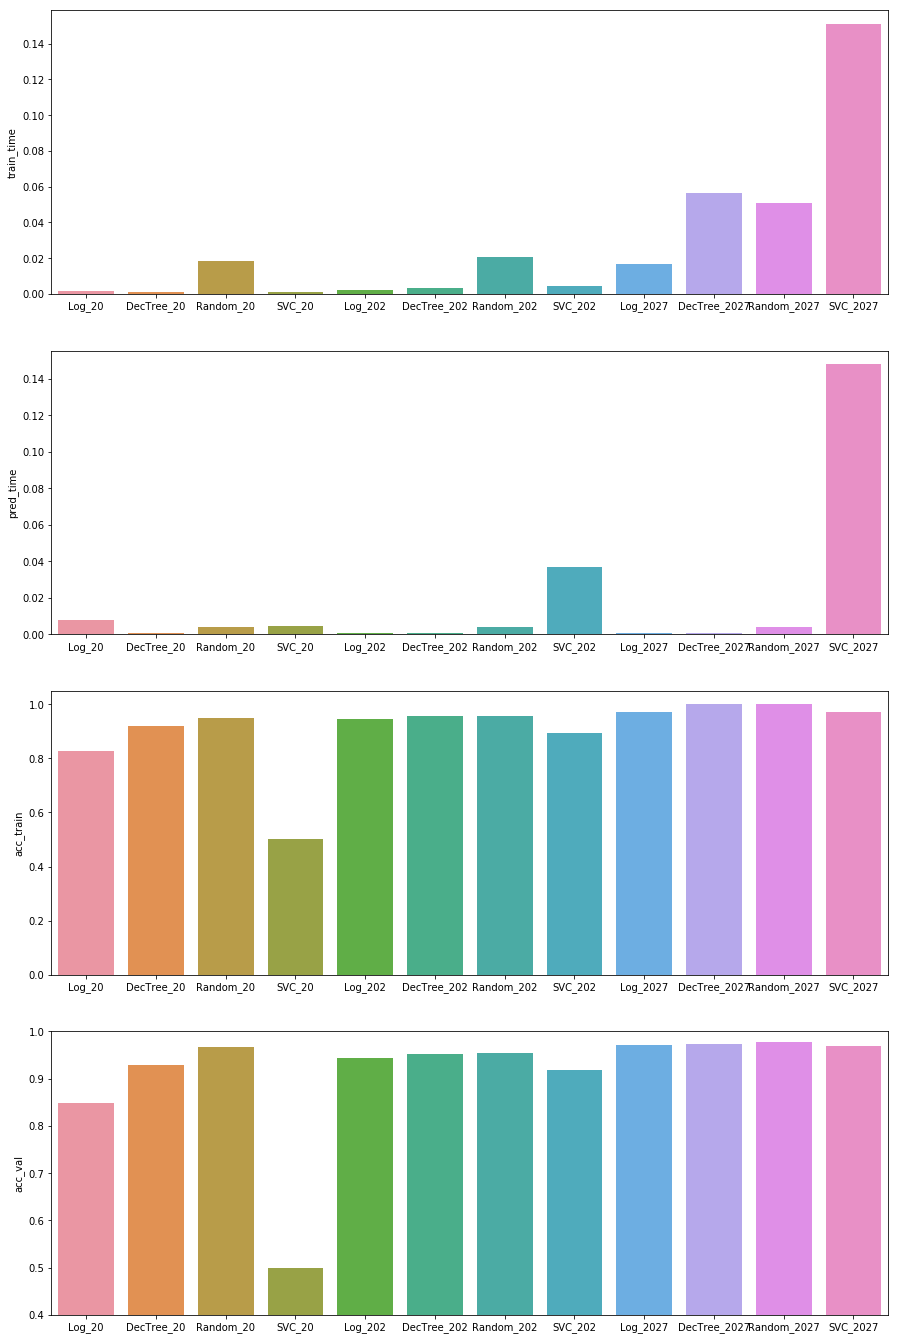

In [249]:
# show results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 24))
for axi, compare in zip([ax1, ax2, ax3, ax4], ["train_time", "pred_time", "acc_train", "acc_val"]):
    x = ["{}_{}".format(clf_name, samples) 
         for samples in [samples_1, samples_10, samples_100]
         for clf_name in ["Log", "DecTree", "Random", "SVC"]]
    y = [results[clf.__class__.__name__][i][compare] 
         for i in range(3)
         for clf in [clf_A, clf_B, clf_C, clf_D] ]
    if axi is ax4:
        plt.ylim((0.4, 1))
    sns.barplot(x, y, ax = axi)
    axi.set_ylabel(compare)
        
plt.show()
fig.savefig("Four_model_compare.svg")

---
## Optimize Model
Use GridSearchCV to optimize the models.

In [277]:
# import model selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

def optimize_model(learner, parameters, X_train, y_train, X_val, y_val):

    results = {}
    
    # use grid search, accuarcy as scoring standard, 5 fold
    grid_obj = GridSearchCV(learner, parameters, scoring = "accuracy", cv = 4)

    # use train data to get best parameters
    grid_obj.fit(X_train, y_train)

    # print best parameters
    print("{}'s best parameters: {}".format(learner.__class__.__name__, grid_obj.best_params_))
    
    # get best estimator
    best_learner = grid_obj.best_estimator_
    
    start = time()
    clone(best_learner).fit(X_train, y_train)
    end = time()
    
    # get time for training
    results['train_time'] = end - start
    
    # predict validation and train set, and record time
    start = time()
    predictions_val = best_learner.predict(X_val)
    predictions_train = best_learner.predict(X_train)
    end = time()
    
    # get predict time
    results['pred_time'] = end - start
            
    # get training accuracy
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # get validation accuaray
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    return best_learner, results

Optimized parameters:
- LogisticRegression:
    - C: Inverse of regularization strength. Smaller, stronger regularization
    - solver: Algorithm to use to optimize

- DecisionTree:
    - criterion: How to calculate the quality of a split
    - max_depth: The max depth of the tree
    
- RandomForest:
    - n_estimators: The number of trees.
    - criterion
    - max_depth
    
- SVC:
    - C: penalty of the error term
    - gamma: kernel coefficient

In [390]:
# init model
clf_A = LogisticRegression(random_state = 68)
clf_B = DecisionTreeClassifier(random_state = 157)
clf_C = RandomForestClassifier(random_state = 271)
clf_D = SVC(probability=True, random_state = 452)

# the parameters to try
parameters_A = {
    "C": [0.5, 1.0, 2.0],
    "solver": ['liblinear', 'sag', 'saga']
}

parameters_B = {
    "criterion": ["gini", "entropy"],
    "max_depth": [8, 10, 12]
}

parameters_C = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [8, 10, 12]
}

parameters_D = {
    "C": [0.1, 0.5, 1.0],
    "gamma": [1, 3, 5, 7]
}
# collect results
results = {}
best_clf = {}
for (clf, parameters) in zip([clf_A, clf_B, clf_C, clf_D],
                             [parameters_A, parameters_B, parameters_C, parameters_D]):
    clf_name = clf.__class__.__name__
    best_clf[clf_name], results[clf_name]= optimize_model(clf, parameters, X_train, y_train, X_val, y_val)

LogisticRegression's best parameters: {'C': 2.0, 'solver': 'liblinear'}
DecisionTreeClassifier's best parameters: {'criterion': 'entropy', 'max_depth': 8}
RandomForestClassifier's best parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 100}
SVC's best parameters: {'C': 1.0, 'gamma': 5}


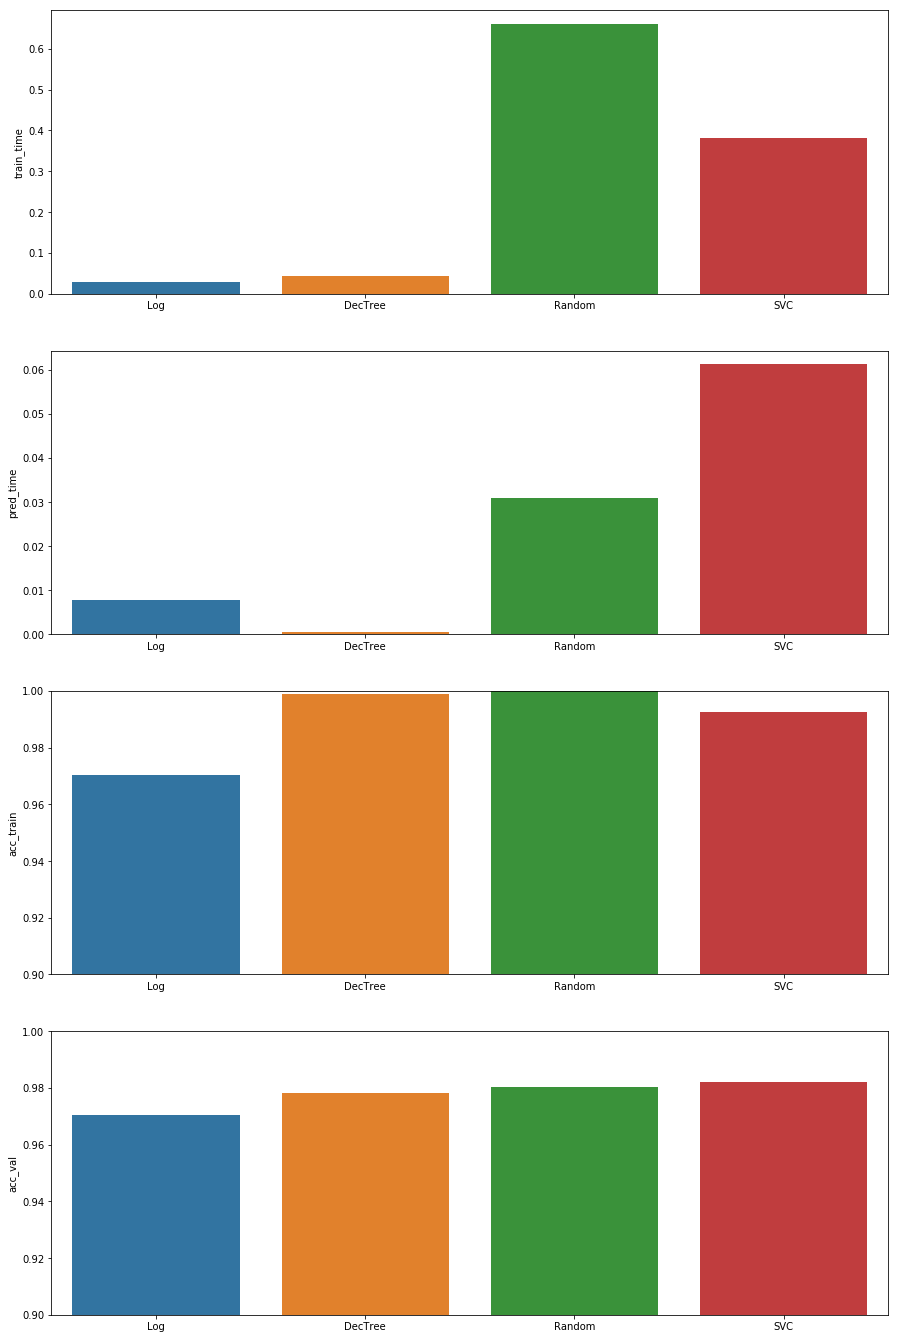

In [391]:
# show results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 24))
ax3.set_ylim((0.9, 1))
ax4.set_ylim((0.9, 1))
for axi, compare in zip([ax1, ax2, ax3, ax4], ["train_time", "pred_time", "acc_train", "acc_val"]):
    x = ["Log", "DecTree", "Random", "SVC"]
    y = [results[clf.__class__.__name__][compare] 
         for clf in [clf_A, clf_B, clf_C, clf_D] ]
    sns.barplot(x, y, ax = axi)
    axi.set_ylabel(compare)
        
plt.show()
fig.savefig("Four_optimized_model_compare.svg")

We can see that RandomForest achieves highest validation accuracy and costs accpetable predicting and training time. Thus, RandomForest is chosen as the final model.

In [392]:
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(best_clf["SVC"].score(X_val, y_val)))


Optimized Model
------
Final accuracy score on the validation data: 0.9822


---
## Feature Importance
Not all the features contribute a lot. In fact, some important features can provide enough information.

For example, the male's voice sounds thick than the female's. So, perhaps we can get pretty good results just using `meanfun`.



### How accuracy changes with important features

In [254]:
from sklearn.base import clone
def train_important_feature(learner, sorted_importance, feature_ctr, X_train, y_train, X_val, y_val):
    
    # reduce feature space
    columns_reduced = X_train.columns.values[sorted_importance[:feature_ctr]] 
    X_train_reduced = X_train[columns_reduced]
    X_val_reduced = X_val[columns_reduced]

    # get a model based on parameters of best estimator
    print("Training on model with {} most important feature(s)".format(feature_ctr))
    clf_on_reduced = (clone(learner)).fit(X_train_reduced, y_train)

    # predict
    train_reduced_predictions = clf_on_reduced.predict(X_train_reduced)
    val_reduced_predictions = clf_on_reduced.predict(X_val_reduced)
    
    return accuracy_score(y_train, train_reduced_predictions), accuracy_score(y_val, val_reduced_predictions)

The way to extract feature importance from SVC is finded there: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

In [326]:
importance_results_train = []
importance_results_val = []

#best_random_forest = best_clf["RandomForestClassifier"]
# train a model
# model = RandomForestClassifier(random_state = 125)
model = SVC(kernel="linear")
model.fit(X_train, y_train)

# get importances
importances = abs(model.coef_.ravel())
#importances = abs(best_clf["SVC"].coef_.ravel())
#importances = best_random_forest.feature_importances_
sorted_importances = np.argsort(importances)[::-1]
for feature_ctr in range(1,20):
    acc_train, acc_val = train_important_feature(best_clf["SVC"],
            sorted_importances, feature_ctr, X_train, y_train, X_val, y_val)
    importance_results_train.append(acc_train)
    importance_results_val.append(acc_val)

Training on model with 1 most important feature(s)
Training on model with 2 most important feature(s)
Training on model with 3 most important feature(s)
Training on model with 4 most important feature(s)
Training on model with 5 most important feature(s)
Training on model with 6 most important feature(s)
Training on model with 7 most important feature(s)
Training on model with 8 most important feature(s)
Training on model with 9 most important feature(s)
Training on model with 10 most important feature(s)
Training on model with 11 most important feature(s)
Training on model with 12 most important feature(s)
Training on model with 13 most important feature(s)
Training on model with 14 most important feature(s)
Training on model with 15 most important feature(s)
Training on model with 16 most important feature(s)
Training on model with 17 most important feature(s)
Training on model with 18 most important feature(s)
Training on model with 19 most important feature(s)


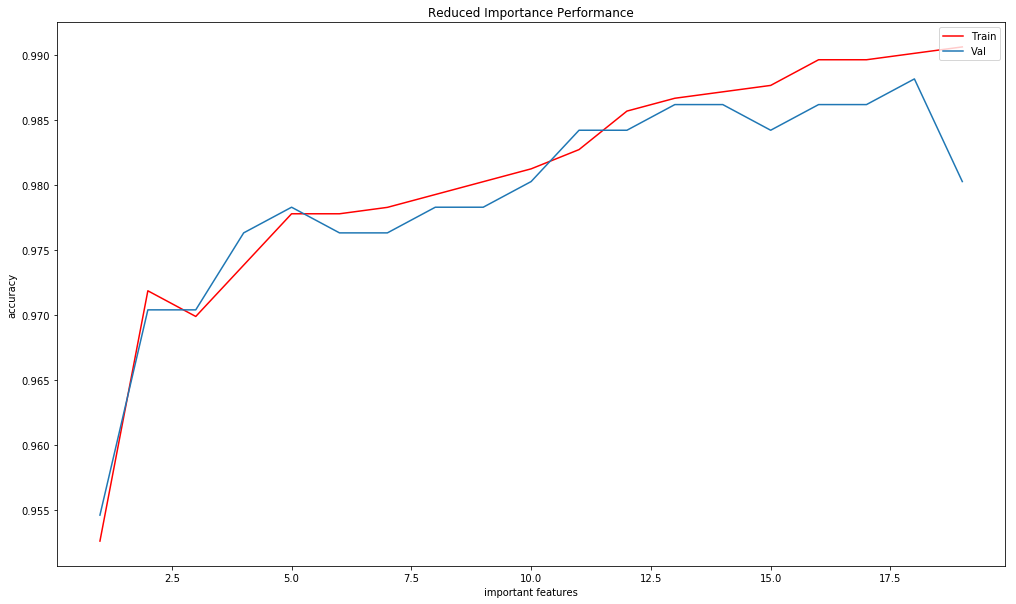

In [327]:
fig, ax = plt.subplots(1, 1, figsize = (17, 10))
ax.plot(range(1,20), importance_results_train, 'r',
        range(1,20), importance_results_val)
ax.set_xlabel("important features")
ax.set_ylabel("accuracy")
ax.legend(('Train', 'Val'), loc='upper right')
plt.title("Reduced Importance Performance")
plt.show()
fig.savefig("reduce_performance.svg")

According to the plot, **13** is the point with least difference between training accuracy and validation accuracy among the points above 0.980.

### The Top-13 important Features

First, list the features according to importance.

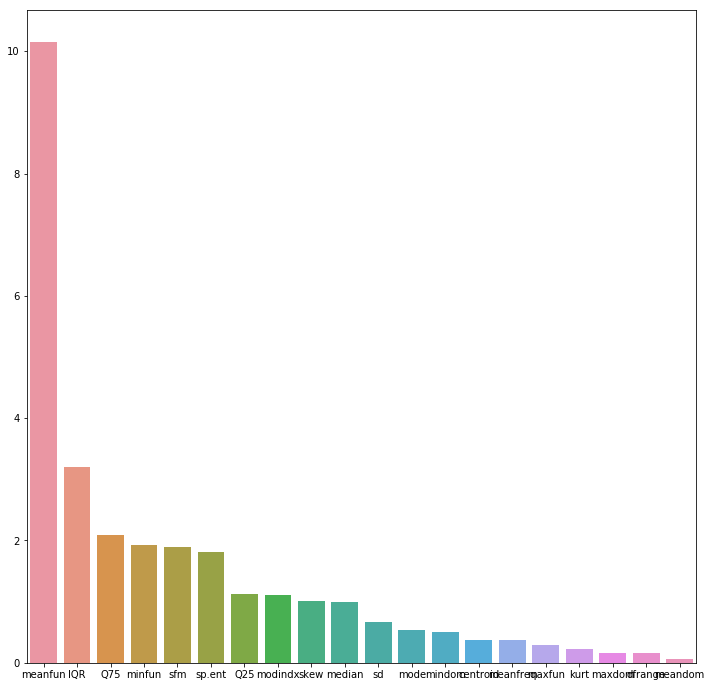

In [331]:
# sort importances
columns = X_train.columns.values[sorted_importances[:20]]
values = importances[sorted_importances][:20]

# draw
fig, _ = plt.subplots(figsize = (12, 12))
sns.barplot(columns, values)
plt.show()
fig.savefig("Feature_importance.svg")

The top-13 important features are `meanfun`, `IQR`, `Q75`, `minfun`, `sfm`, `sp.ent`, `Q25`, `modindx`, `skew`, `median`, `sd`, `mode`, `mindom`. And 3 of them, `IQR`, `meanfun`, `sd` matches observation before.


### Reduce Feature Space

Only using the top-13 important feautures can simplift the model, save time for training and predicting. And it is convenient for application since only 13 features of original wave need to be extracted.

In [393]:
from sklearn.base import clone

results["reduced_SVC"] = {}

# reduce feature space
X_train_reduced = X_train[X_train.columns.values[sorted_importances[:13]]]
X_val_reduced = X_val[X_val.columns.values[sorted_importances[:13]]]

# get a model based on parameters of best estimator
clf_on_reduced = clone(best_clf["SVC"])
start = time()
clf_on_reduced.fit(X_train_reduced, y_train)
end = time()

results["reduced_SVC"]["train_time"] = end - start;

start = time()
clf_on_reduced.predict(X_val_reduced)
end = time()

results["reduced_SVC"]["pred_time"] = end - start;


# sum up
print("Final Model trained on full data\n------")
print("Accuracy on train data: {:.4f}".format(results["SVC"]["acc_train"]))
print("Accuracy on validation data: {:.4f}".format(results["SVC"]["acc_val"]))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on train data: {:.4f}".format(clf_on_reduced.score(X_train_reduced, y_train)))
print("Accuracy on validation data: {:.4f}".format(clf_on_reduced.score(X_val_reduced, y_val)))

Final Model trained on full data
------
Accuracy on train data: 0.9926
Accuracy on validation data: 0.9822

Final Model trained on reduced data
------
Accuracy on train data: 0.9867
Accuracy on validation data: 0.9862


The reduced model has similiar accuracy on training dataset and validation dataset, so it should have good generalizaion performance.

## Testing

In [394]:
for model_name in best_clf.keys():
    print("\nFinal {} trained on full data\n------".format(model_name))
    print("Final accuracy score on the train data: {:.4f}".format(results[model_name]["acc_train"]))
    print("Final accuracy score on the val data: {:.4f}".format(results[model_name]["acc_val"]))
    print("Final accuracy score on the test data: {:.4f}".format(best_clf[model_name].score(X_test, y_test)))


Final LogisticRegression trained on full data
------
Final accuracy score on the train data: 0.9704
Final accuracy score on the val data: 0.9704
Final accuracy score on the test data: 0.9637

Final DecisionTreeClassifier trained on full data
------
Final accuracy score on the train data: 0.9990
Final accuracy score on the val data: 0.9783
Final accuracy score on the test data: 0.9653

Final RandomForestClassifier trained on full data
------
Final accuracy score on the train data: 1.0000
Final accuracy score on the val data: 0.9803
Final accuracy score on the test data: 0.9795

Final SVC trained on full data
------
Final accuracy score on the train data: 0.9926
Final accuracy score on the val data: 0.9822
Final accuracy score on the test data: 0.9811


In [395]:
for model_name in best_clf.keys():
    print("\nFinal {} trained on full data\n------".format(model_name))
    print("Training time: {:.4f}".format(results[model_name]["train_time"]))
    print("Predicting time: {:.4f}".format(results[model_name]["pred_time"]))


Final LogisticRegression trained on full data
------
Training time: 0.0289
Predicting time: 0.0078

Final DecisionTreeClassifier trained on full data
------
Training time: 0.0431
Predicting time: 0.0006

Final RandomForestClassifier trained on full data
------
Training time: 0.6614
Predicting time: 0.0310

Final SVC trained on full data
------
Training time: 0.3816
Predicting time: 0.0613


In [396]:
X_test_reduced = X_test[X_test.columns.values[sorted_importances[:13]]]
print("\nFinal Model trained on reduced data\n------")
print("Final accuracy score on the train data: {:.4f}".format(clf_on_reduced.score(X_train_reduced, y_train)))
print("Final accuracy score on the val data: {:.4f}".format(clf_on_reduced.score(X_val_reduced, y_val)))
print("Final accuracy score on the test data: {:.4f}".format(clf_on_reduced.score(X_test_reduced, y_test)))


Final Model trained on reduced data
------
Final accuracy score on the train data: 0.9867
Final accuracy score on the val data: 0.9862
Final accuracy score on the test data: 0.9795


In [397]:
print("\nFinal Model trained on reduced data\n------")
print("Training time: {:.4f}".format(results["reduced_SVC"]["train_time"]))
print("Predicting time: {:.4f}".format(results["reduced_SVC"]["pred_time"]))


Final Model trained on reduced data
------
Training time: 0.2682
Predicting time: 0.0074


After reduction, the model has low variances(< 1% difference between training data and testing data) and still achieve high testing accuracy of 97.95%. Considering the decreased amount of calculation and simplification of feature extracting, it is reasonible to use the reduced model for application.

---
## Save Model

In [398]:
with open('model.pkl', 'wb') as fid:
    pickle.dump(clf_on_reduced, fid,2) 

In [399]:
features_min_reduced = features_min[sorted_importances[:13]]
features_max_reduced = features_max[sorted_importances[:13]]
with open('scale.pkl', 'wb') as fid:
    pickle.dump((features_min_reduced, features_max_reduced), fid,2) 